<h1 style="text-align:center">Advanced Statistical Inference</h1>
<h1 style="text-align:center">Feature selection</h1>

## 1. Aims
<div class="alert alert-info">
To carry out feature selection on the leukaemia data.
</div>

## 2. Feature selection 
<div class="alert alert-info">
On the course webpage, you can download a (slightly reduced) version of the leukaemia data. It consists of some training data $X$ and associated labels $t$ as well as independent test data $X_{test}$ and $t_{test}$. Your task is to select some features and classify the data – in previous labs we have implemented code for classification and you may use whichever you like.
</div>

In [1]:
import scipy.io
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.datasets.samples_generator import make_blobs

leuk = scipy.io.loadmat('projection_files/labdata.mat')

In [2]:
X = leuk['X']
t = leuk['t'][:,0]
X_test = leuk['X_test']
t_test = leuk['t_test'][:,0]

<div class="alert alert-info">
Observe the class distribution of the data.
</div>

In [3]:
print("[TRAINSET]")
print("Data:  ", X.shape)
print("Labels:", t.shape)
print("Ratio leukaemia/healthy samples: %d/%d\n" % (len(t[t == 1]), len(t[t == 0])))

print("[TESTSET]")
print("Data:  ", X_test.shape)
print("Labels:", t_test.shape)
print("Ratio leukaemia/healthy samples: %d/%d" % (len(t_test[t_test == 1]), len(t_test[t_test == 0])))

[TRAINSET]
Data:   (38, 300)
Labels: (38,)
Ratio leukaemia/healthy samples: 11/27

[TESTSET]
Data:   (34, 300)
Labels: (34,)
Ratio leukaemia/healthy samples: 14/20


### 2.1 Feature selection 
<div class="alert alert-info">
You are free to use any of the feature selection schemes we covered – scoring the features, PCA, or clustering them (you should already have $k$-means code to do this). In each case, you should use the test set to investigate how performance varies as you change the number of features.</div>

#### 2.1.1 Scoring 
<div class="alert alert-info">
Use the scoring mechanism described in the lectures (only on the training data) to obtain a set of features (corresponding to a subset of the original ones). You should make sure you extract this subset from the test data too!
</div>

In [19]:
def compute_s(feature, t):
    
    mu1 = np.mean(feature[t.astype(bool)])
    mu0 = np.mean(feature[np.logical_not(t)])

    var1 = np.var(feature[t.astype(bool)])
    var0 = np.var(feature[np.logical_not(t)])
    
    return np.abs(mu1 - mu0) / (var0 + var1)


def order_features_by_score(X, t):
    
    scores = []
    
    for f in range(X.shape[1]):
        scores.append((f, compute_s(X[:,f], t)))
    
    scores.sort(key = lambda x: x[1], reverse=True)
    
    return np.array([x[0] for x in scores]), np.array([x[1] for x in scores])

In [20]:
ordered_features, scores = order_features_by_score(X, t)

print("Ordered features")
for i in range(10):
    print("Feature:", ordered_features[i], "\tScore:", scores[i])

Ordered features
Feature: 50 	Score: 6.011058037272707
Feature: 129 	Score: 4.577095690783484
Feature: 179 	Score: 4.451846850434148
Feature: 190 	Score: 4.424452000674534
Feature: 29 	Score: 4.420369389720395
Feature: 39 	Score: 4.396030068393235
Feature: 96 	Score: 4.353329041559556
Feature: 13 	Score: 4.329837643000831
Feature: 143 	Score: 4.3000163383796055
Feature: 166 	Score: 4.193222001809674


<div class="alert alert-info">
Plot the data by considering the top 2 features and comment on the results.
</div>

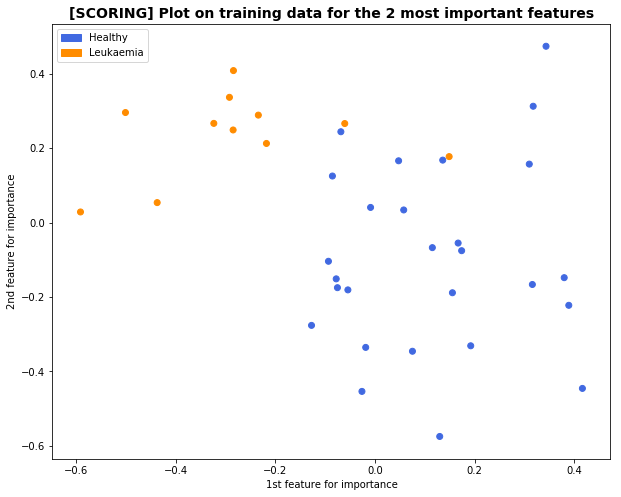

In [21]:
colour = ["royalblue", "darkorange"]
plt.figure(figsize=(10,8))
plt.scatter(X[:,ordered_features[0]], X[:,ordered_features[1]], c = [colour[t] for t in t])
plt.title("[SCORING] Plot on training data for the 2 most important features", fontsize=14, weight="semibold")
plt.xlabel("1st feature for importance")
plt.ylabel("2nd feature for importance")
royalblue_patch = mpatches.Patch(color='royalblue', label='Healthy')
darkorange_patch = mpatches.Patch(color='darkorange', label='Leukaemia')
plt.legend(handles=[royalblue_patch, darkorange_patch])
plt.show()

<div class="alert alert-info">
Does the visualisation of separate classes improve if you consider the top 3 features instead?</div>

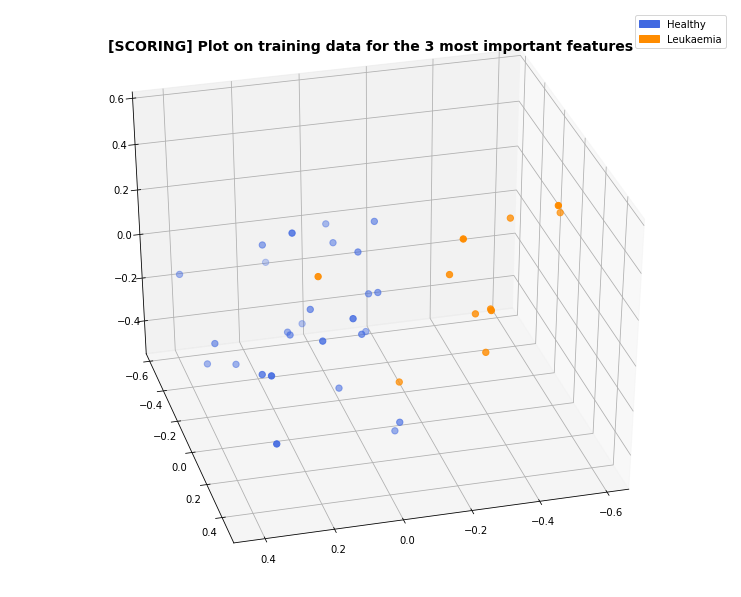

In [22]:
fig = plt.figure(1, figsize=(10, 8))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=35, azim=75)
plt.cla()
ax.scatter(X[:,ordered_features[0]], X[:,ordered_features[1]], \
           X[:,ordered_features[2]], c = [colour[t] for t in t], s=40)
plt.title("[SCORING] Plot on training data for the 3 most important features", fontsize=14, weight="semibold")
royalblue_patch = mpatches.Patch(color='royalblue', label='Healthy')
darkorange_patch = mpatches.Patch(color='darkorange', label='Leukaemia')
plt.legend(handles=[royalblue_patch, darkorange_patch])
plt.show()

#### 2.1.2 Clustering
<div class="alert alert-info">

You can use the $k$-means code you implemented in the previous notebook. Remember to pass the data the correct way around and only cluster the training data. Transforming the test data is a little more complex – your $k$-means should give you assignments of features to clusters. Use these alongside the test data to compute the cluster means for the test data (you do not need to re-assign the clusterings).

</div>

In [8]:
import math
from itertools import cycle, islice

def kmeans(X, k, maxiter, seed=None, centroids=None):
    
    # Initializations
    n = len(X[:,0])
    assignments = np.empty(n, dtype=int)
    
    # First random assignment
    np.random.seed(seed)
    centr_idx = np.random.choice(n,k,replace=False)
    centroids = np.array(X[centr_idx,:])
    
    # Main loop
    for t in range(0,maxiter):
        
        # ASSIGNMENT PHASE
        # Compute distance matrix
        dist_mat = pairwise_distances(X, centroids, metric='sqeuclidean')
        
        # Find minimum for each row
        assignments = np.argmin(dist_mat, 1);
        
       
        # UPDATE PHASE
        # Compute new centroids and update
        backup = np.copy(centroids)
        for c in range(0,k):
            centroids[c,0] = np.mean(X[assignments == c,0])
            centroids[c,1] = np.mean(X[assignments == c,1])
            
        # STOP CONDITION
        if np.all(centroids == backup):
            break
        
    return centroids, assignments

In [33]:
def runKmeans(k):

    maxiter = 50
    seed = None
    
    # Run (with transposed X, to do it on features)
    centroids, assignments = kmeans(X.T, k, maxiter, seed)
    
    return centroids, assignments

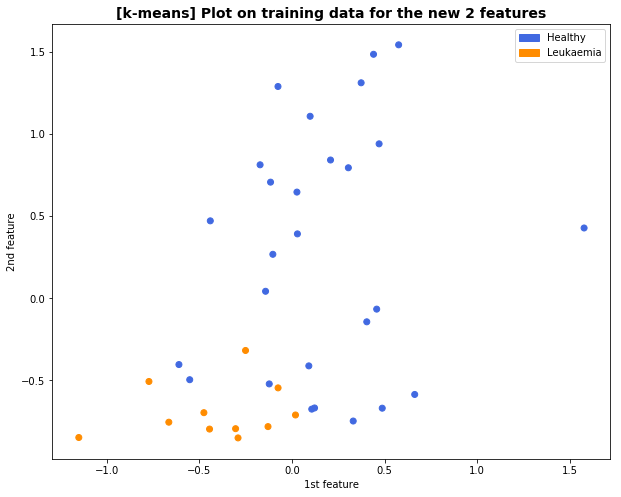

In [36]:
centroids, assignments = runKmeans(2)
centroids = centroids.T
colour = ["royalblue", "darkorange"]
plt.figure(figsize=(10,8))
plt.scatter(centroids[:,0], centroids[:,1], c = [colour[t] for t in t])
plt.title("[k-means] Plot on training data for the new 2 features", fontsize=14, weight="semibold")
plt.xlabel("1st feature")
plt.ylabel("2nd feature")
royalblue_patch = mpatches.Patch(color='royalblue', label='Healthy')
darkorange_patch = mpatches.Patch(color='darkorange', label='Leukaemia')
plt.legend(handles=[royalblue_patch, darkorange_patch])
plt.show()

#### 2.1.3 Principal components
<div class="alert alert-info">
Implement a function for obtaining the $k$ principal components of your data.
Try to avoid using 'sklearn' libraries for this task!
</div>

In [25]:
import numpy as np
from scipy import linalg

def pca_k(X, k):
    
    m, n = X.shape
    
    # mean center the data
    X -= X.mean(axis=0)
    
    # calculate the covariance matrix
    R = np.cov(X, rowvar=False)
    
    # calculate eigenvectors & eigenvalues of the covariance matrix
    # use 'eigh' rather than 'eig' since R is symmetric, 
    # the performance gain is substantial
    evals, evecs = linalg.eigh(R)
    
    # sort eigenvalue in decreasing order
    idx = np.argsort(evals)[::-1]
    
    # sort eigenvectors according to same index
    evecs = evecs[:,idx]
    
    # sort eigenvalues according to same index
    evals = evals[idx]
    
    # select the first n eigenvectors (n is desired dimension
    # of rescaled data array, or dims_rescaled_data)
    evecs = evecs[:, :k]
    
    # carry out the transformation on the data using eigenvectors
    # and return the re-scaled data, eigenvalues, and eigenvectors
    return np.dot(X, evecs), evals, evecs

<div class="alert alert-info">
As before, compare and contrast the effectiveness of using PCA when considering 2 and 3 principal components, respectively.<br>
Plot your results using scatter plots and comment on what you observe.
</div>

In [26]:
X_red, evals, evecs = pca_k(X, 2)

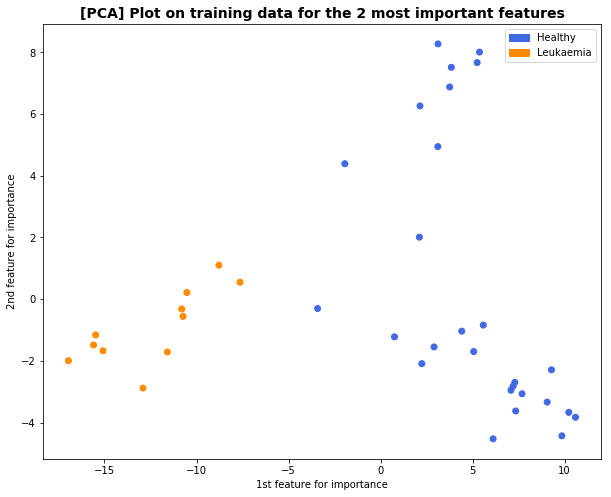

In [27]:
colour = ["royalblue", "darkorange"]
plt.figure(figsize=(10,8))
plt.scatter(X_red[:,0], X_red[:,1], c = [colour[t] for t in t])
plt.title("[PCA] Plot on training data for the 2 most important features", fontsize=14, weight="semibold")
plt.xlabel("1st feature for importance")
plt.ylabel("2nd feature for importance")
royalblue_patch = mpatches.Patch(color='royalblue', label='Healthy')
darkorange_patch = mpatches.Patch(color='darkorange', label='Leukaemia')
plt.legend(handles=[royalblue_patch, darkorange_patch])
plt.show()

In [28]:
X_red, evals, evecs = pca_k(X, 3)

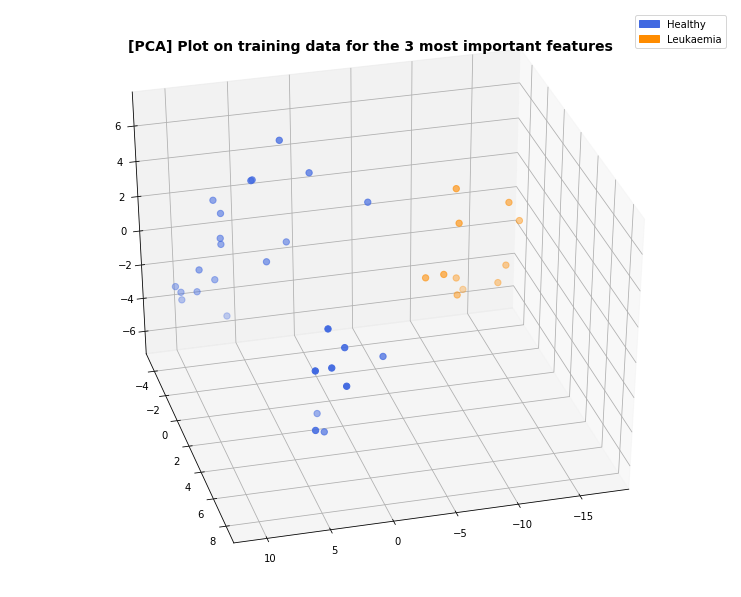

In [29]:
fig = plt.figure(1, figsize=(10, 8))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=35, azim=75)
plt.cla()
ax.scatter(X_red[:,0], X_red[:,1], X_red[:,2], c = [colour[t] for t in t], s=40)
plt.title("[PCA] Plot on training data for the 3 most important features", fontsize=14, weight="semibold")
royalblue_patch = mpatches.Patch(color='royalblue', label='Healthy')
darkorange_patch = mpatches.Patch(color='darkorange', label='Leukaemia')
plt.legend(handles=[royalblue_patch, darkorange_patch])
plt.show()

## 3. Classification
<div class="alert alert-info">
Insofar, we have only considered how carrying out dimensionality reduction allows us to _visually_ distinguish the different classes of the dataset.<br><br>

Using any of the classification algorithms we developed in the previous lectures, assess how classification performance varies when carrying out any of the above feature selection techniques as a preprocessing step. </div>

In [42]:
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.metrics import accuracy_score

# K-FOLD CROSS-VAL
for i in range(2, 20):
    
    kf = KFold(n_splits=X.shape[0])
    accuracies = []
    
    for train_i, test_i in kf.split(X):
        
        # Reduction
        ordered_features = order_features_by_score(X[train_i], t[train_i])[0][:i]
        X_train_red = X[train_i,:][:,ordered_features]
        X_test_red = X[test_i, :][:,ordered_features]
        
        model = svm.SVC(kernel='linear')
        
        model.fit(X_train_red, t[train_i]);
        
        pred = model.predict(X_test_red)
        
        accuracies.append(accuracy_score(t[test_i], pred))
    
    acc = np.mean(accuracies)
    print("#Features: %d, accuracy=%.2f" % (i, acc))

#Features: 2, accuracy=0.58
#Features: 3, accuracy=0.53
#Features: 4, accuracy=0.66
#Features: 5, accuracy=0.74
#Features: 6, accuracy=0.76
#Features: 7, accuracy=0.82
#Features: 8, accuracy=0.82
#Features: 9, accuracy=0.82
#Features: 10, accuracy=0.89
#Features: 11, accuracy=0.92
#Features: 12, accuracy=0.95
#Features: 13, accuracy=0.92
#Features: 14, accuracy=0.92
#Features: 15, accuracy=0.92
#Features: 16, accuracy=0.95
#Features: 17, accuracy=0.97
#Features: 18, accuracy=1.00
#Features: 19, accuracy=1.00


18 features are enough to have 1.00 accuracy!